# Statistics on the point sources

In [18]:
import os , glob
import os.path as path
import pandas as pd

import matplotlib.pyplot as plt
import random
import numpy as np

from scipy.stats import sigmaclip
from astropy.io import fits
from math import *
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix

import networkx as nx

## Constants
DEG2ARCSEC= 3600.

In [19]:
## Directories
wdir =  "/home/stephane/Science/RadioGalaxy/DeepField/bosscha/analysis/catalog"
plotdir =  "/home/stephane/Science/RadioGalaxy/DeepField/bosscha/analysis/plots"

In [20]:
## Functions

def spectralIndex(f, flux):
    spix = (log(flux[1]) - log(flux[0])) / (log(f[1]) - log(f[0]))
    
    return(spix)

## find counterparts
##  
## ra, dec: array of all sources
## label: each source should have a different label
## 

class ctrprt:
    
    def __init__(self, ra, dec, label):
        self.ra= ra
        self.dec= dec
        self.label= label
        
    def setFlux(self, flux):
        self.flux= flux
              
    ## basic algorithm to connect one source at different frequencies.
    ## IMPORTANT: tolerance should be small enough to avoid two different sources at the "same" position
    def getGraphSource(self, tolerance= 0.5):
        K= []
        G=nx.Graph()
        tolerance /= DEG2ARCSEC
        
        for i in range(len(self.ra)):
            K.append([self.ra[i], self.dec[i]])
            G.add_node(i)
            dist= distance_matrix(K, K)
        
        pair= []
        for i in range(len(self.ra)):
            for j in range(i):
                if dist[i,j] < tolerance and self.label[i] != self.label[j]:
                    G.add_edge(i,j, weight= dist[i,j])
                    
        ## removing isolated nodes (detections)
        isol= list(nx.isolates(G))
        G.remove_nodes_from(list(nx.isolates(G)))
        
        return(G , isol)
    
    
    
    
    def getMultipleDetection(self, G):
        cont= True
        sources=[]
        
        if len(G.nodes) == 0:
            return([])
        
        while cont:
            list_node= list(G.nodes)
            first_node= list_node[0]
            
            ## all nodes reachable from one node (same source)
            connected_nodes= list(nx.descendants(G,first_node))
            connected_nodes.append(first_node)
            connected_nodes.sort()
            
            sources.append(connected_nodes)
            
            for v in connected_nodes:
                    G.remove_node(v)
            
            if len(G.nodes)==0:
                cont= False
        
        return(sources)
    
    
    
def matchsou(filecat, wdir, tolsep= 0.5):
    "match point source and updt df"
        
    totalMatchSou= 0
    for f in filecat:
        print("### file: %s"%(f))
        df= pd.read_csv(f)
        t = ctrprt(df.ra,df.dec,df.label)
        g, isol= t.getGraphSource(tolsep)  
        sources= t.getMultipleDetection(g)
        print(sources)
            
        npoinsou= len(df.ra)
        souindex= np.zeros(npoinsou,dtype=int)
        if len(sources) > 0:
            indsou= 1  ## first matching
            for s in sources:
                souindex[s]= indsou
                indsou += 1
                totalMatchSou += 1
            
        df["poinsou"]= souindex
        df.to_csv(os.path.join(wdir,f)+'.test') 
            
    print("###\n### Total matched sources: %d\n"%(totalMatchSou))
        

In [21]:
os.chdir(wdir)

print("## Matching the sources...")
filecat= glob.glob("*.cat.csv")

### matching point sources
toleranceSeparation= 0.5
## matchsou(filecat, wdir, tolsep= toleranceSeparation)
     

## Matching the sources...


### Spectral indices ..

In [22]:
### UGLY fix if same frequency..
def fixsamefreq(fr, fl):
    print("fix..")
    
    frnew= []
    flnew= []
    wei= []
    
    print(fr)
    for i in range(len(fr)):
        print(fr[i])
        if fr[i] not in frnew:
            frnew.append(fr[i])
            flnew.append(fl[i])
            wei.append(1.0)
            
        else:
            for k in range(len(frnew)):
                if frnew[k] == fr[i]:
                    flnew[k] += fl[i]
                    wei[k] += 1
        
    for i in range(len(frnew)):
        fl[i] = fl[i] / wei[i]
        
        
    return(frnew, flnew)

### plot spectral index source i..

def plotSI(df, name, plotdir):
    nmatch= max(df.poinsou)
    
    for i in range(1,nmatch+1):
        dfsou= df.loc[df.poinsou == i]
        
        print("## Source: %d"%(i))
        # print(dfsou)
        
        fr1= dfsou.frequency.tolist()
        fl1= dfsou.flux.tolist()
        
        fr, fl = fixsamefreq(fr1, fl1)
    
        fig= plt.figure(figsize=(7,5))
        ax= plt.subplot(111)
        plt.title("%s"%(name))
        plt.grid(True)
        plt.xlabel("Freq (GHz)")
        plt.ylabel("Flux (Jy)")
        plt.plot(fr, fl,"r-")
        plt.plot(fr, fl,"k*")
    
        for k in range(1,len(fr)):
            si= spectralIndex([fr[k-1],fr[k]],[fl[k-1],fl[k]] )
            plt.text(0.5*(fr[k-1]+fr[k]) , 0.5*(fl[k-1]+fl[k]) , "SI= %3.3f"%(si) )
    
        filefig= os.path.join(plotdir, name+"-%d.png"%(i))
        plt.savefig(filefig)
        plt.show()
        

## plot sources

def plotSou(df, name, plotdir, fov= 0.0166):
    "plot sources"
    
    fluxmax = max(df.flux)
    dfcenter= df.loc[df.flux == fluxmax]
    
    alphacenter= dfcenter.ra.tolist()[0]
    deltacenter= dfcenter.dec.tolist()[0]
    
    print(alphacenter)
    
    alpha= df.ra.tolist()
    delta= df.dec.tolist()
    
    fig= plt.figure(figsize=(7,5))
    ax= plt.subplot(111)
    plt.title("%s"%(name))
    plt.grid(True)
    
    plt.xlim([alphacenter-fov/2., alphacenter+fov/2.])
    plt.ylim([deltacenter-fov/2., deltacenter+fov/2.])    
    
    plt.xlabel("RA (degree)")
    plt.ylabel("Dec (degree)")
    plt.plot(alpha,delta,"k*")
            
    filefig= os.path.join(plotdir, name+"-loc.png")
    plt.savefig(filefig)
    plt.show()
    

## J1751+0939.cat.csv.test
267.8867441


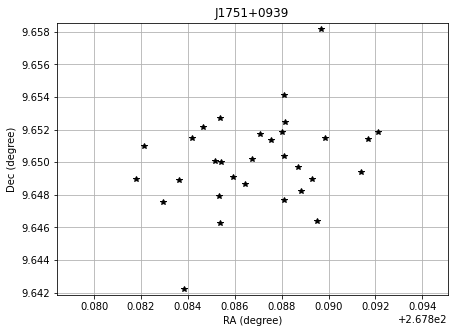

## J2056-4714.cat.csv.test
314.0681646000001


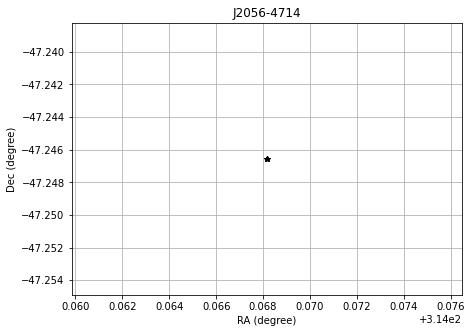

## J1037-2934.cat.csv.test
159.3170061


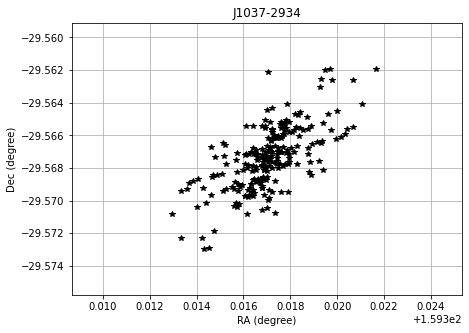

## J1427-4206.cat.csv.test
216.9845712


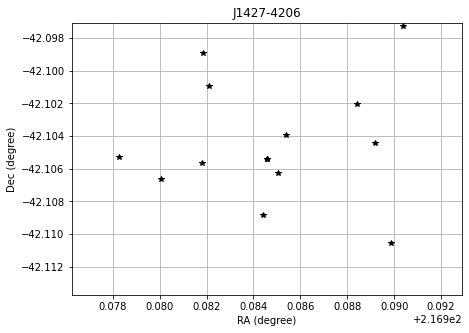

## J0438+3004.cat.csv.test
69.5206196


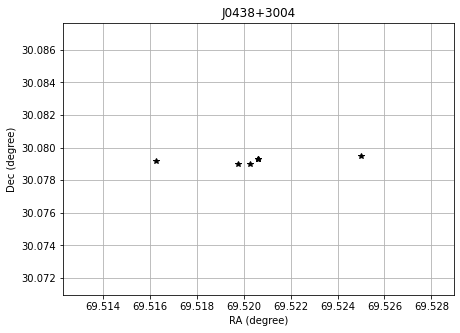

## J1337-1257.cat.csv.test
204.4157667


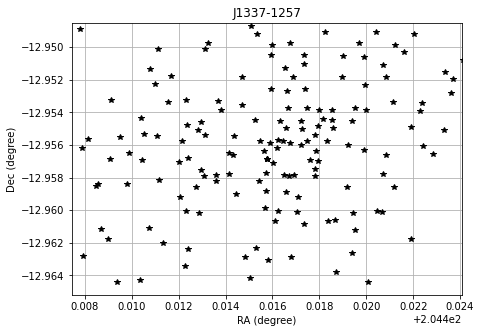

## J2226+0052.cat.csv.test
336.6939084


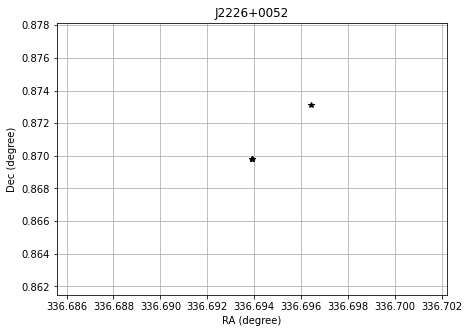

## J0237+2848.cat.csv.test
39.4683684


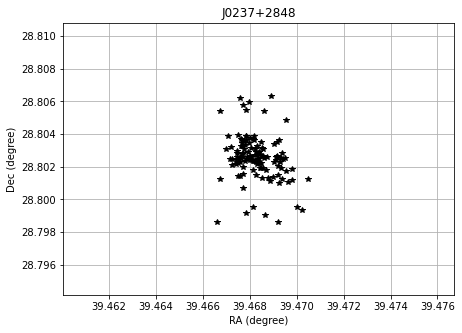

## J2246-1206.cat.csv.test
341.5759699


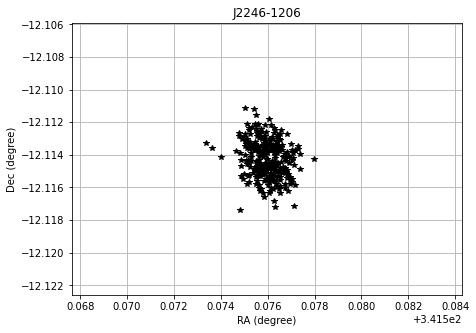

## J0208-0047.cat.csv.test
32.1097795


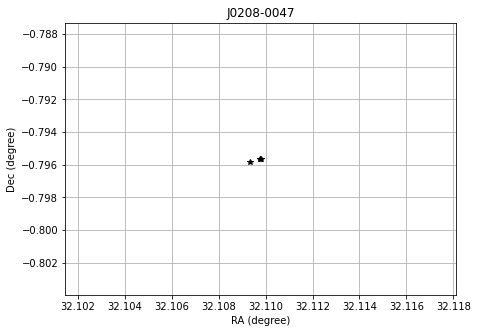

## J0811-4929.cat.csv.test
122.7866935


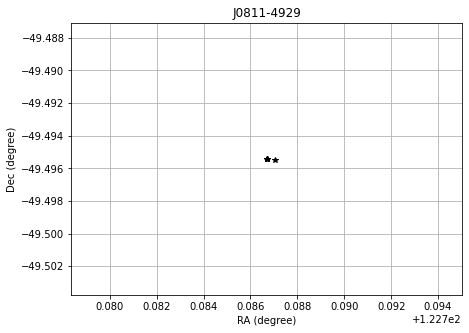

## 3c454.3.cat.csv.test
343.4906164


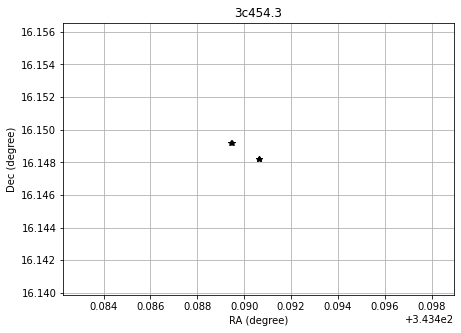

## J2035+1056.cat.csv.test
308.8430601


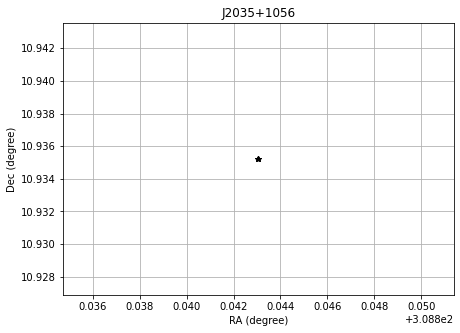

## J1118+1234.cat.csv.test
169.7387595


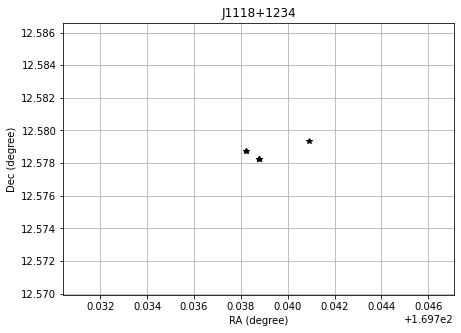

## J0541-0211.cat.csv.test
85.3404011


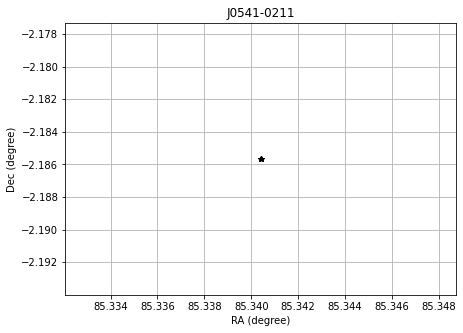

## J1256-0547.cat.csv.test
194.0465321


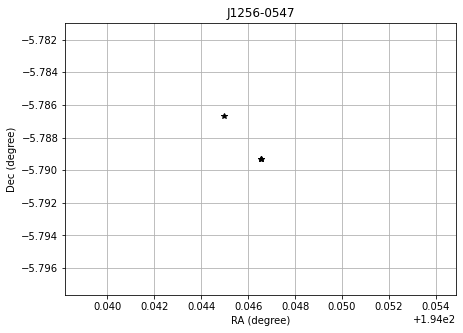

## J1752-2956.cat.csv.test
268.1379496


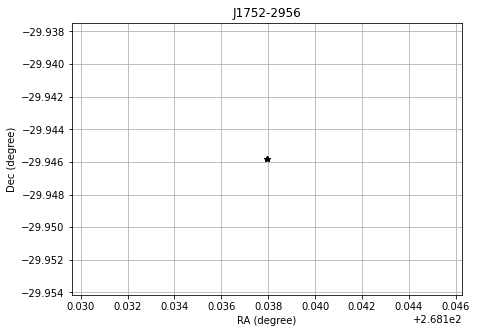

## J1058-8003.cat.csv.test
164.6804756


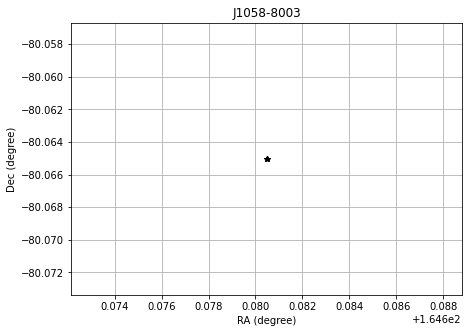

## J1107-4449.cat.csv.test
166.786225


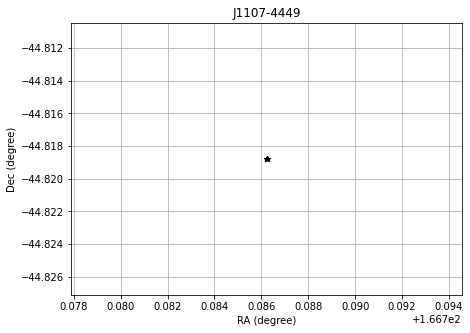

## J0506-6109.cat.csv.test
76.6832532


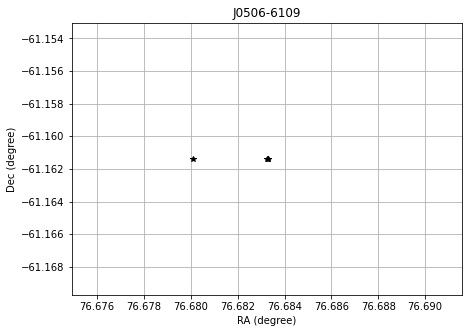

## J1924-2914.cat.csv.test
291.21273439999993


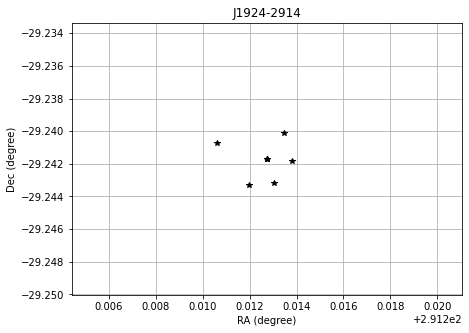

## J0238+1636.cat.csv.test
39.6622124


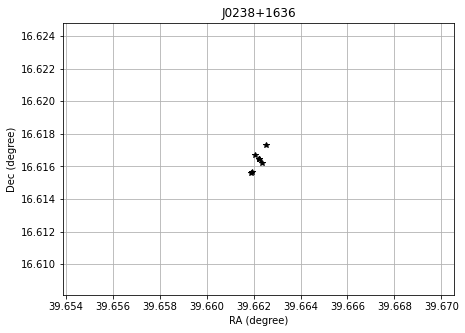

## J2056-5820.cat.csv.test
314.1273518000001


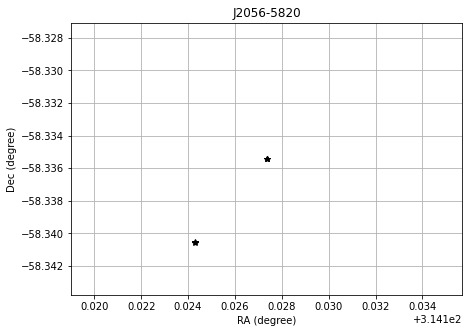

## J1717-3342.cat.csv.test
259.4001252


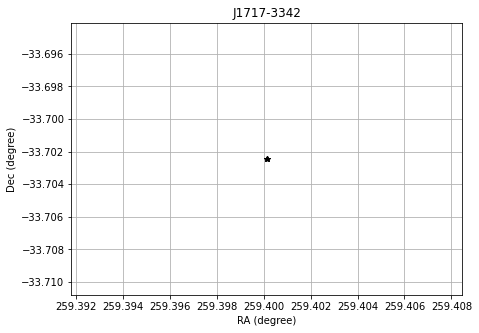

## J1517-2422.cat.csv.test
229.4242238


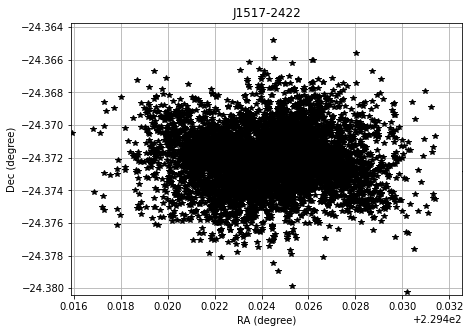

## J0750+1231.cat.csv.test
117.7168602


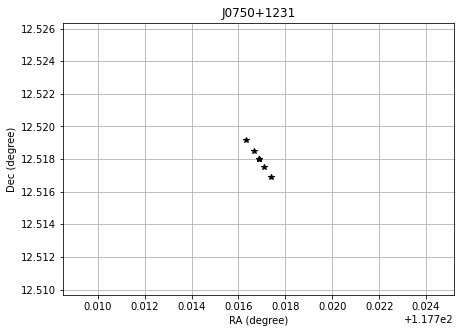

## J0348-2749.cat.csv.test
57.158938


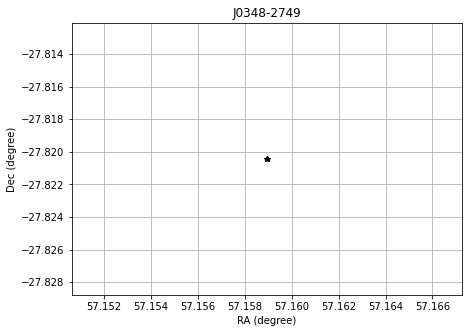

## J2232+1143.cat.csv.test
338.1517088


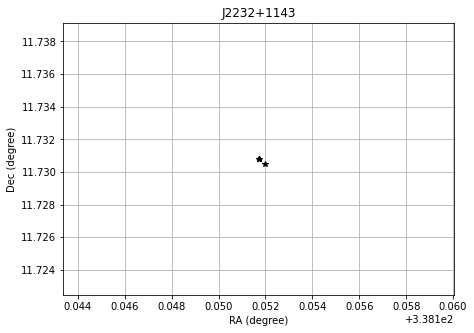

## J1700-2610.cat.csv.test
255.2214751


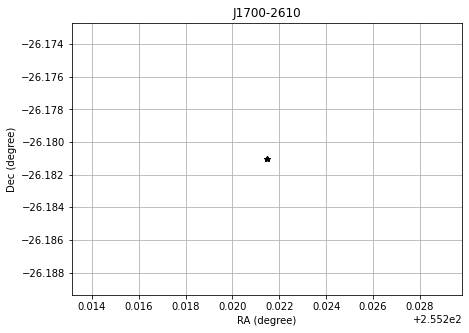

## J0541-0541.cat.csv.test
85.40868090000002


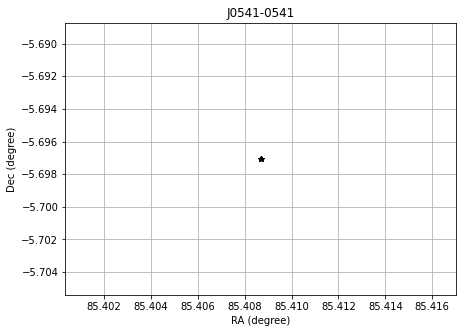

## J0224+0659.cat.csv.test
36.1184508


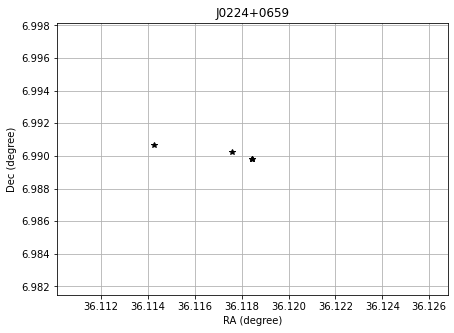

## J0426+2327.cat.csv.test
66.7322299


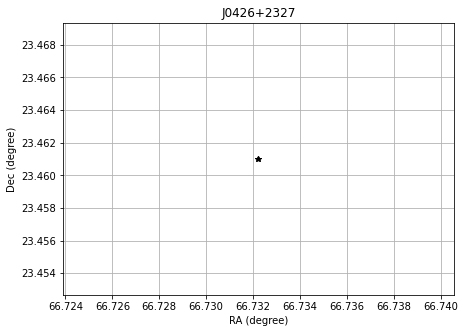

## J0922-3959.cat.csv.test
140.6934105


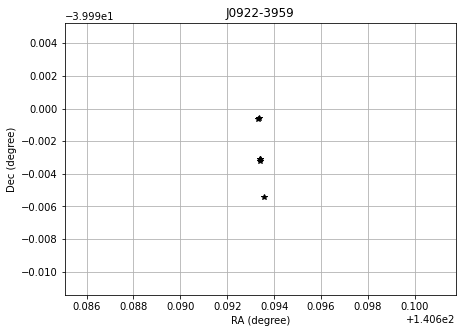

## J1550+0527.cat.csv.test
237.646955


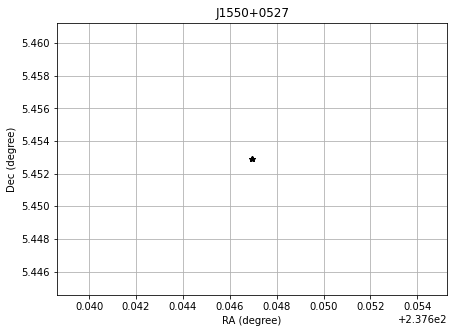

## 4C_-02.55.cat.csv.test
188.0000633


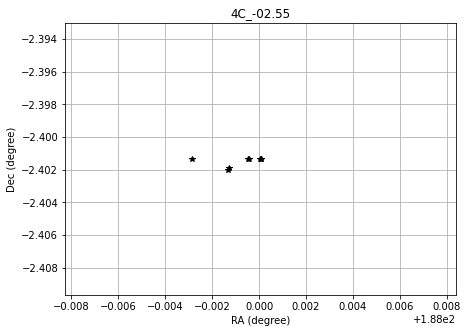

## J0904-5735.cat.csv.test
136.22161780000002


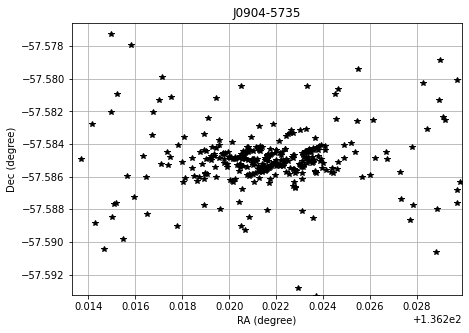

## J2148+0657.cat.csv.test
327.0227451


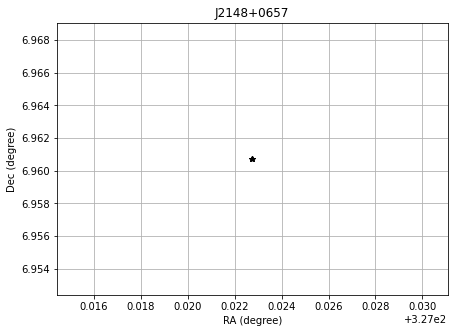

## J0730-1141.cat.csv.test
112.5796354


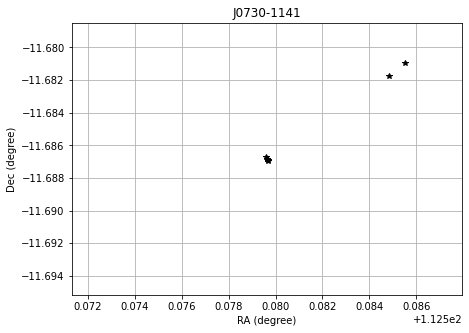

## J1315-5334.cat.csv.test
198.7674267


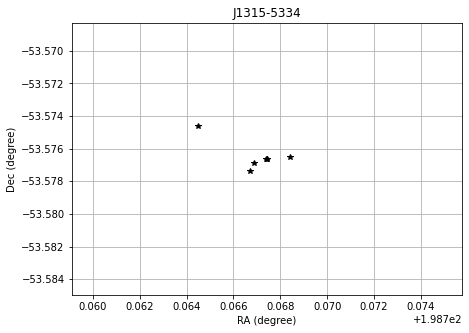

## J0006-0623.cat.csv.test
1.5578912


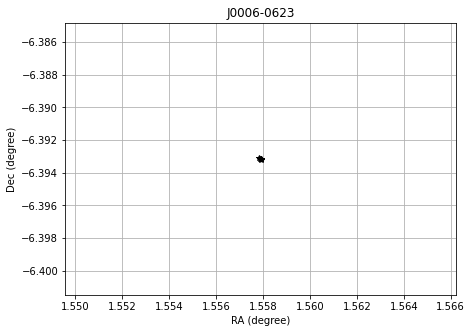

## J1208-7809.cat.csv.test
182.0764916


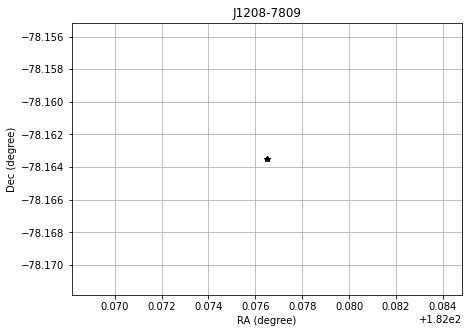

## J0635-7516.cat.csv.test
98.9438056


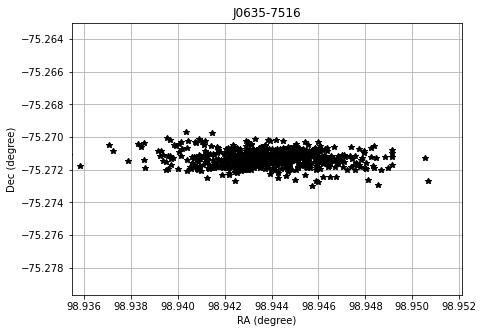

## J0519-4546.cat.csv.test
79.9528707


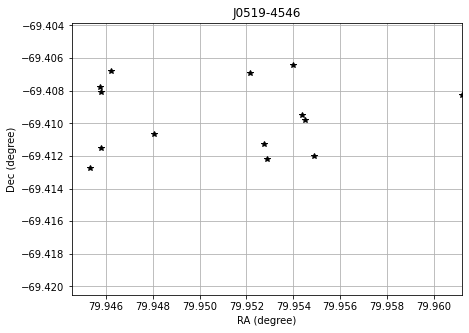

## J0108+0135.cat.csv.test
17.1615463


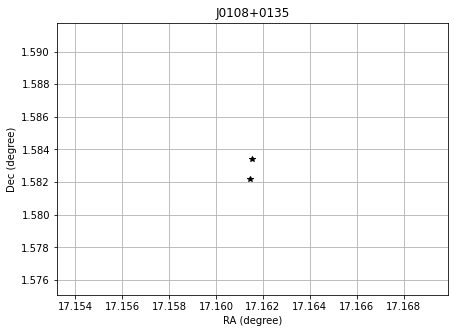

## J2134-0153.cat.csv.test
323.5429606


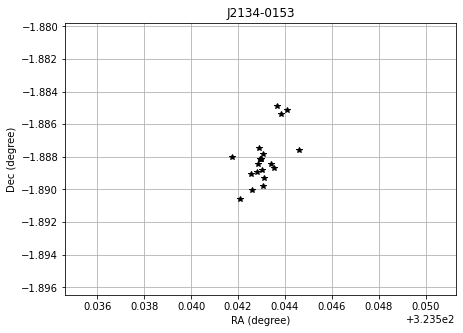

## J0241-0815.cat.csv.test
40.2699937


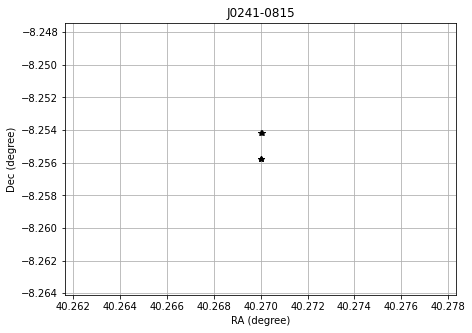

## J0510+1800.cat.csv.test
77.5098708


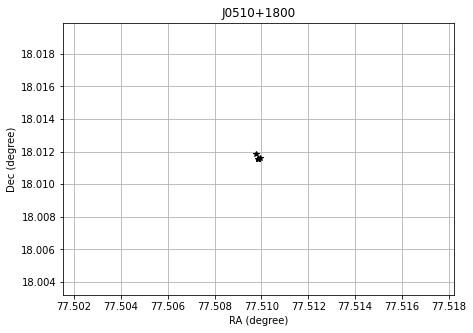

## J0334-4008.cat.csv.test
53.5568938


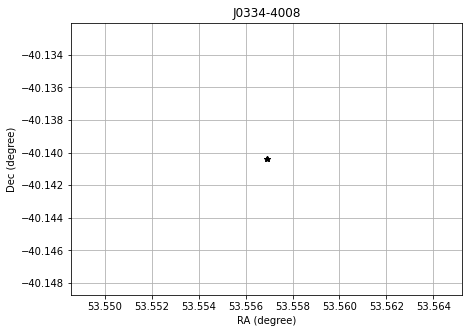

## J1229+0203.cat.csv.test
187.2779206


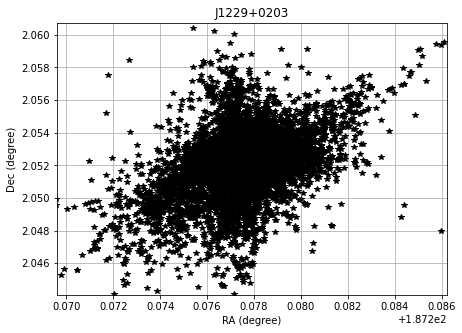

## J1625-2527.cat.csv.test
246.4453819


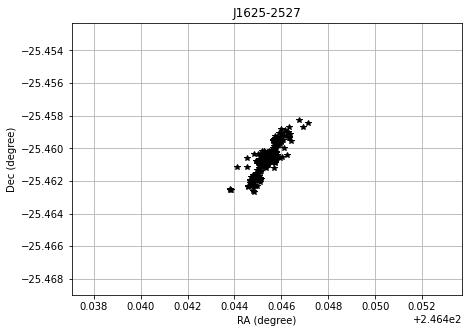

## J0747-3310.cat.csv.test
116.8320129


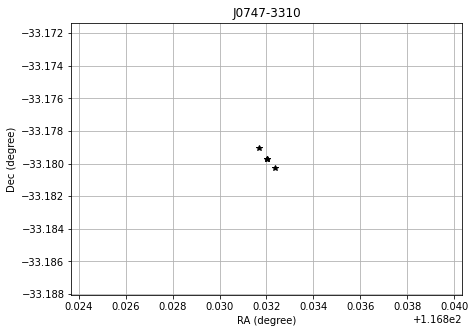

## J0522-3627.cat.csv.test
80.74161120000002


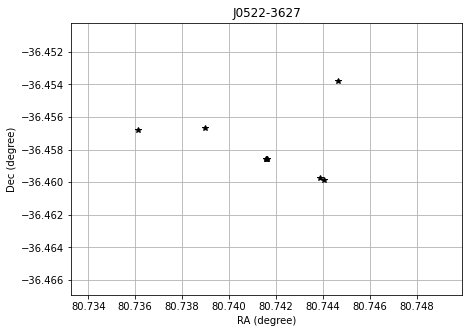

## J0601-7036.cat.csv.test
90.2968663


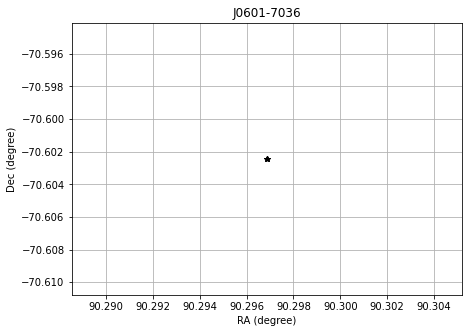

## J0215-0222.cat.csv.test
33.9250714


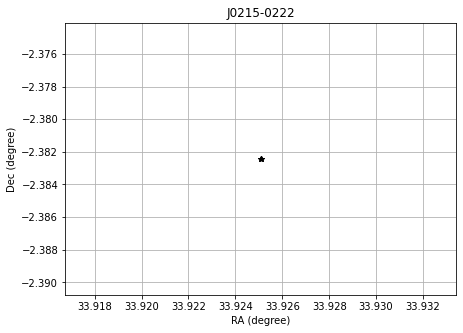

## J1626-2951.cat.csv.test
246.52509


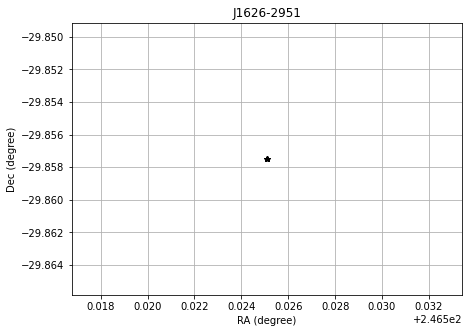

## J0501-0159.cat.csv.test
75.30337390000003


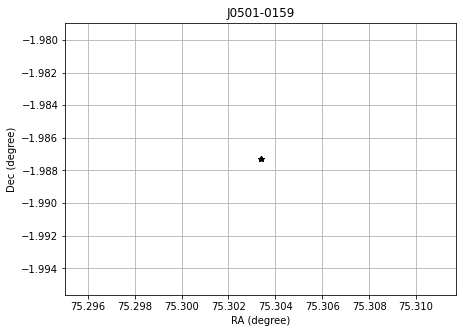

## J0531-4827.cat.csv.test
82.9942379


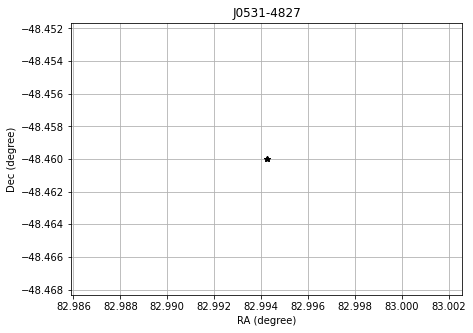

## J0340-2119.cat.csv.test
55.14836579999999


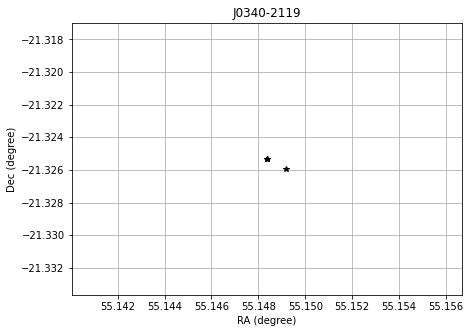

## J0538-4405.cat.csv.test
84.7098493


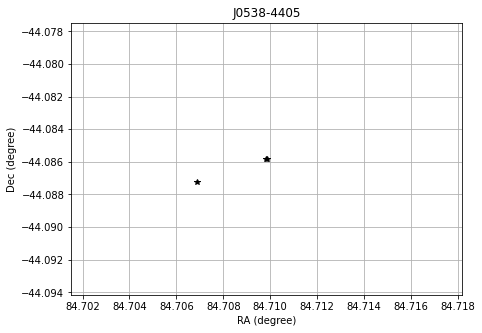

## J0532+0732.cat.csv.test
83.1624937


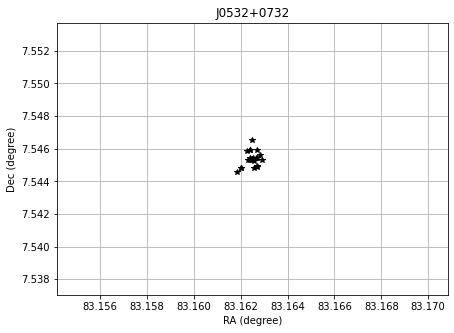

## J1058+0133.cat.csv.test
164.623355


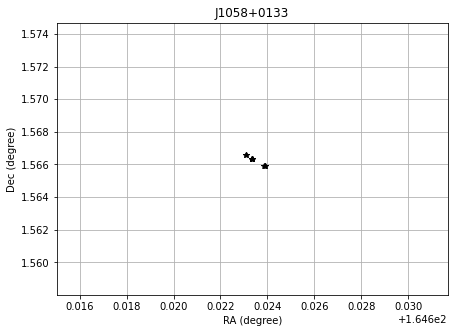

## J1038+0512.cat.csv.test
159.6949198


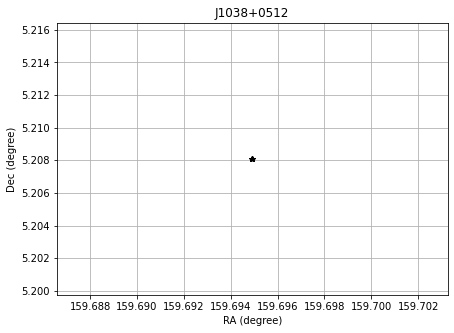

## J0113+0222.cat.csv.test
18.4297719


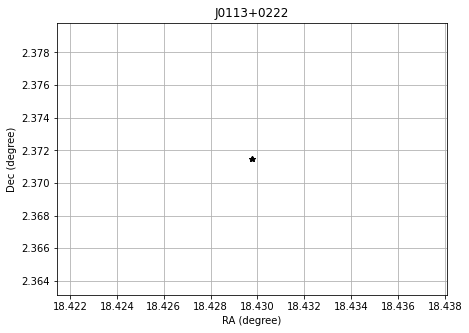

## J0423-0120.cat.csv.test
65.81584029999999


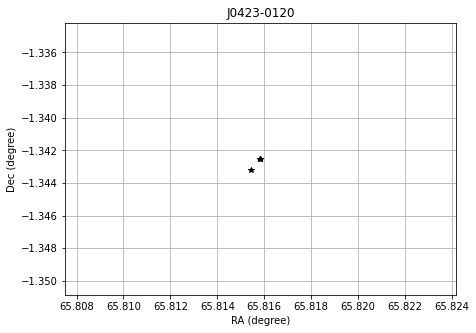

## J1733-1304.cat.csv.test
263.261274


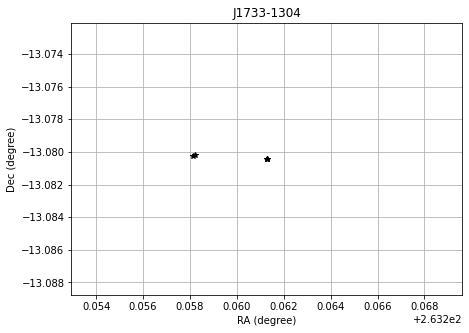

## J1319-0049.cat.csv.test
199.9115234


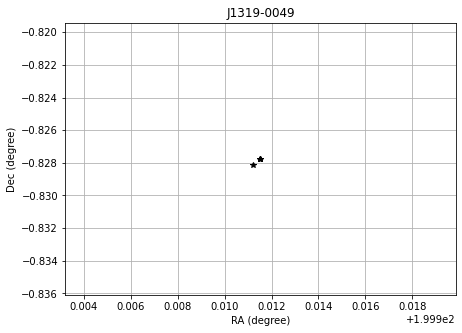

## J0219+0120.cat.csv.test
34.7792689


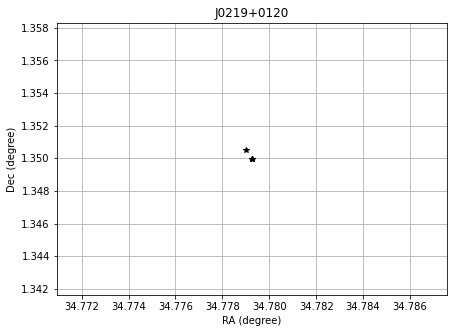

## J0239-0234.cat.csv.test
39.9394719


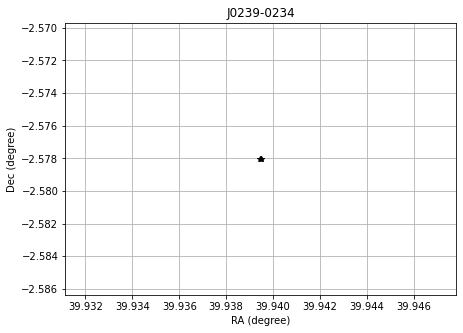

## J1744-3116.cat.csv.test
266.0982427


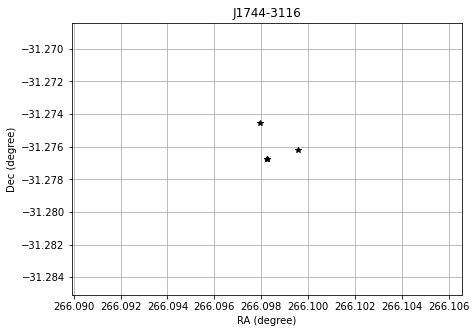

## J0217+0144.cat.csv.test
34.4539782


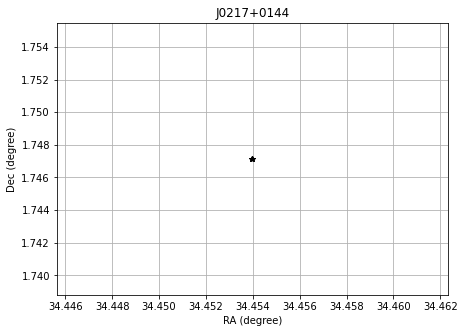

## J1516+1932.cat.csv.test
229.2366506


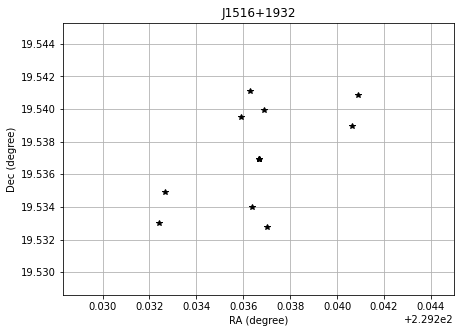

## J0828-3731.cat.csv.test
127.019925


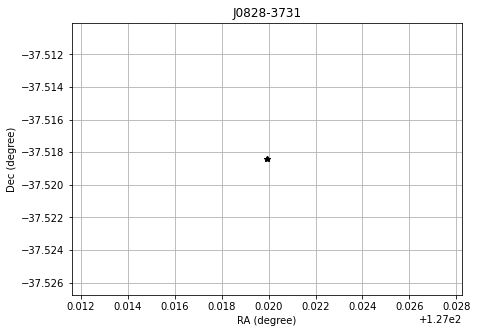

## J2158-1501.cat.csv.test
329.5261746000001


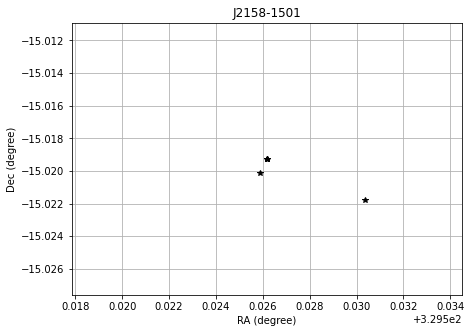

## J2258-2758.cat.csv.test
344.5248478000001


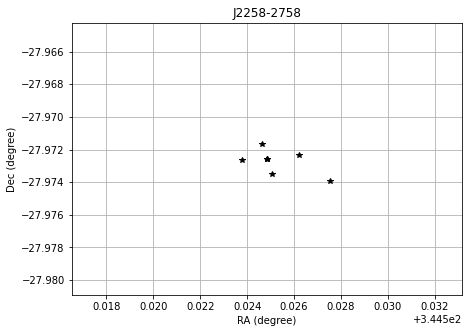

## J0854+2006.cat.csv.test
133.7036482


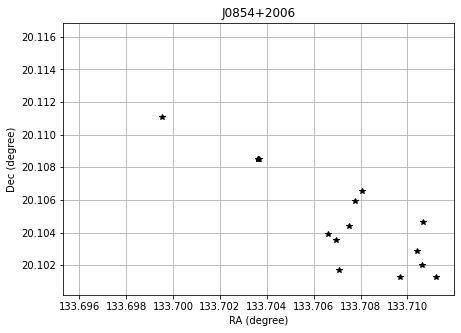

## J1007-0207.cat.csv.test
151.76813049999996


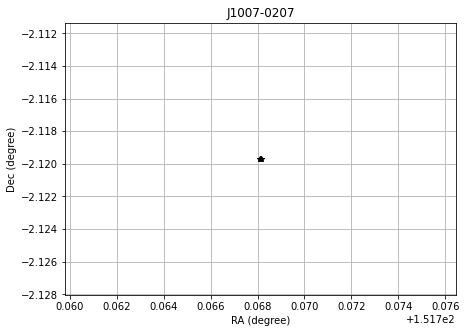

## J0040-3243.cat.csv.test
10.0730878


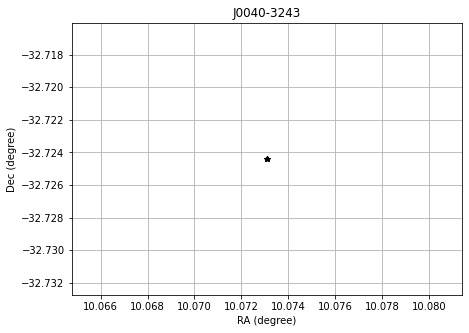

## J0607-0834.cat.csv.test
91.998747


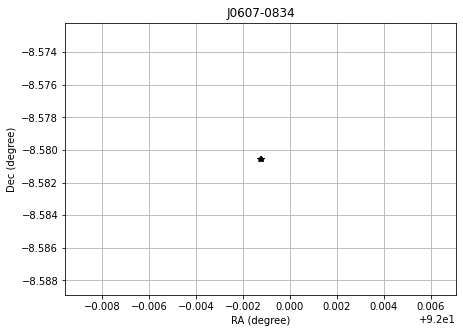

## J2357-5311.cat.csv.test
359.471942


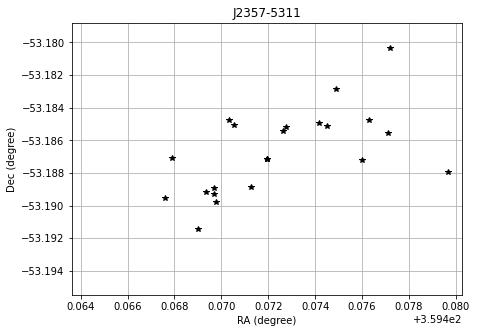

## J1833-2103.cat.csv.test
278.4163073


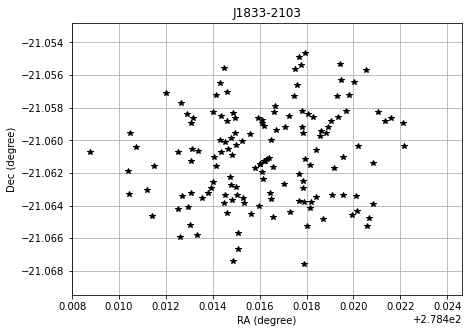

## J0309+1029.cat.csv.test
47.2650979


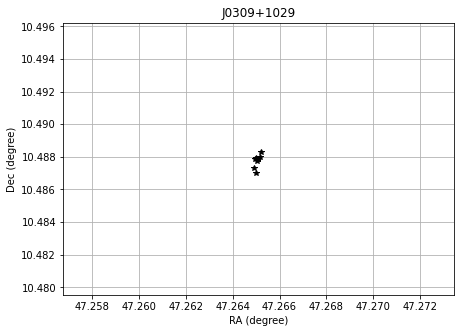

## J0315-1656.cat.csv.test
48.8653299


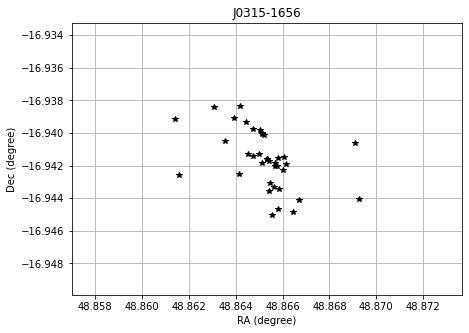

In [23]:
filecat= glob.glob("*.cat.csv.test")


for f in filecat:
    print("## %s"%(f))
    df= pd.read_csv(f)
    name= f[0:-13]
    # plotSI(df, name, plotdir)
    plotSou(df, name, plotdir, fov= 0.01666)
    
    